<a href="https://colab.research.google.com/github/itsmaul/bangkit-progress/blob/main/Selena_App.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CAPSTONE PROJECT - SELENA APP (SELLING, FINANCE, AND ANALYTICS)**

## **Proses Analisis oleh Model ML (Menggunakan File .pkl)**

1. Backend memuat model ML yang sudah dilatih (disimpan dalam format .pkl) menggunakan library Pickle di Python.
2. Model ML ini memproses data transaksi pengguna yang sudah diambil dari database untuk melakukan beberapa tugas analisis:
  - Deteksi Anomali Pengeluaran: Model ML mendeteksi adanya transaksi atau pengeluaran yang tidak biasa atau mencurigakan.
  - Arus Kas: Mengidentifikasi pola pemasukan dan pengeluaran.
  - Saran Keuangan: Berdasarkan analisis tren keuangan pengguna, model bisa memberikan saran, misalnya mengurangi pengeluaran di kategori tertentu.

## **Pengembalian Hasil Analisis ke Backend (ML ke CC)**

1. Model ML menghasilkan output analisis, seperti rekomendasi keuangan dan deteksi anomali, yang dikonversi ke format JSON.
2. Backend menerima hasil ini dan menggabungkannya menjadi satu respons JSON yang siap dikirim ke aplikasi mobile.

### **Import Library yang Digunakan**

In [1]:
import csv
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

### **Convert Excel to CSV**

In [2]:
read_file = pd.read_excel("Order.completed.20240903_20241003.xlsx")
read_file.to_csv("Order.completed.20240903_20241003.csv", header=True)
df = pd.DataFrame(pd.read_csv("Order.completed.20240903_20241003.csv"))
print(df.head())

   Unnamed: 0     No. Pesanan Status Pesanan Status Pembatalan/ Pengembalian  \
0           0  24090319KKAFE8        Selesai                             NaN   
1           1  2409043YH69NTF        Selesai                             NaN   
2           2  2409031QMAU0WH        Selesai                             NaN   
3           3  24090449E4N3U0        Selesai                             NaN   
4           4  2409069M51V33M        Selesai                             NaN   

            No. Resi                  Opsi Pengiriman  \
0  SPXID040285869389  Reguler (Cashless)-SPX Standard   
1  SPXID047799706439  Reguler (Cashless)-SPX Standard   
2  SPXID045570814139  Reguler (Cashless)-SPX Standard   
3      CM93203860375   Reguler (Cashless)-JNE Reguler   
4  SPXID048740532539  Reguler (Cashless)-SPX Standard   

  Antar ke counter/ pick-up  \
0          Antar ke Counter   
1          Antar ke Counter   
2          Antar ke Counter   
3          Antar ke Counter   
4          Antar ke C

### **Assessing Data**

In [3]:
def assessing_data(df):
    print(f"\n---TABLE INFO---\n")
    df.info()

    print(f"\n---MISSING VALUES---\n")
    print(df.isna().sum())

    print(f"\n---DUPLICATE DATA---\n")
    print(df.duplicated().sum())

    print(f"\n---STATISTICS PARAMETER---\n")
    print(df.describe())

In [4]:
assessing_data(df)


---TABLE INFO---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 49 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   Unnamed: 0                                                    112 non-null    int64  
 1   No. Pesanan                                                   112 non-null    object 
 2   Status Pesanan                                                112 non-null    object 
 3   Status Pembatalan/ Pengembalian                               1 non-null      object 
 4   No. Resi                                                      112 non-null    object 
 5   Opsi Pengiriman                                               112 non-null    object 
 6   Antar ke counter/ pick-up                                     112 non-null    object 
 7   Pesanan Harus Dikirimkan Sebelum (Menghindari keterl

### **Cleaning Data**

In [5]:
df = df[df['Status Pembatalan/ Pengembalian'] != 'Permintaan Disetujui']

In [6]:
df.rename(columns={'Jumlah Produk di Pesan': 'Jumlah Pemesanan'}, inplace=True)

<ipython-input-6-a6fcb73df647>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Jumlah Produk di Pesan': 'Jumlah Pemesanan'}, inplace=True)


In [7]:
totalbayar_column = ["Total Pembayaran"]

for column in totalbayar_column:
    df[column] = df[column].astype(str)
    df[column] = df[column].str.replace('.', '', regex=False).astype(int)

<ipython-input-7-ee20d05e945e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].astype(str)
<ipython-input-7-ee20d05e945e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].str.replace('.', '', regex=False).astype(int)


In [8]:
datetime_column = ["Waktu Pesanan Selesai"]

for column in datetime_column:
    df[column] = pd.to_datetime(df[column])

<ipython-input-8-1c1408a6f515>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = pd.to_datetime(df[column])


In [9]:
selected_columns = ['Jumlah Pemesanan', 'Total Pembayaran', 'Waktu Pesanan Selesai']
assessing_data(df[selected_columns])


---TABLE INFO---

<class 'pandas.core.frame.DataFrame'>
Index: 111 entries, 0 to 111
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Jumlah Pemesanan       111 non-null    int64         
 1   Total Pembayaran       111 non-null    int64         
 2   Waktu Pesanan Selesai  111 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 3.5 KB

---MISSING VALUES---

Jumlah Pemesanan         0
Total Pembayaran         0
Waktu Pesanan Selesai    0
dtype: int64

---DUPLICATE DATA---

4

---STATISTICS PARAMETER---

       Jumlah Pemesanan  Total Pembayaran          Waktu Pesanan Selesai
count        111.000000      1.110000e+02                            111
mean           1.108108      1.443431e+05  2024-09-24 14:18:21.621621760
min            1.000000      3.100000e+04            2024-09-06 13:19:00
25%            1.000000      8.100000e+04            2024-09-15 23:

### **Exploratory Data Analysis**

In [10]:
df[selected_columns].sample(10)

,Jumlah Pemesanan,Total Pembayaran,Waktu Pesanan Selesai
30,1,208610,2024-09-16 15:01:00
12,1,319601,2024-09-11 05:46:00
37,1,434411,2024-09-18 15:37:00
13,1,551982,2024-09-11 18:41:00
57,1,103049,2024-09-22 06:21:00
35,1,81000,2024-09-18 10:00:00
92,1,179360,2024-10-07 11:16:00
28,1,100805,2024-09-16 07:59:00
63,1,113720,2024-09-24 17:18:00
79,1,45716,2024-10-02 14:17:00


## **TIME SERIES**

In [11]:
DATA_PATH = 'Order.completed.20240903_20241003.csv'

with open(DATA_PATH, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

,No. Pesanan,Status Pesanan,Status Pembatalan/ Pengembalian,No. Resi,Opsi Pengiriman,Antar ke counter/ pick-up,Pesanan Harus Dikirimkan Sebelum (Menghindari keterlambatan),Waktu Pengiriman Diatur,Waktu Pesanan Dibuat,Waktu Pembayaran Dilakukan,Metode Pembayaran,SKU Induk,Nama Produk,Nomor Referensi SKU,Nama Variasi,Harga Awal,Harga Setelah Diskon,Jumlah,Returned quantity,Total Harga Produk,Total Diskon,Diskon Dari Penjual,Diskon Dari Shopee,Berat Produk,Jumlah Produk di Pesan,Total Berat,Voucher Ditanggung Penjual,Cashback Koin,Voucher Ditanggung Shopee,Paket Diskon,Paket Diskon (Diskon dari Shopee),Paket Diskon (Diskon dari Penjual),Potongan Koin Shopee,Diskon Kartu Kredit,Ongkos Kirim Dibayar oleh Pembeli,Estimasi Potongan Biaya Pengiriman,Ongkos Kirim Pengembalian Barang,Total Pembayaran,Perkiraan Ongkos Kirim,Catatan dari Pembeli,Catatan,Username (Pembeli),Nama Penerima,No. Telepon,Alamat Pengiriman,Kota/Kabupaten,Provinsi,Waktu Pesanan Selesai

First data 

In [12]:
def plot_series(time, series, format="-", start=0, end=None):
    """Plot the series"""
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Date")
    plt.ylabel("Income")
    plt.grid(True)

In [13]:
def parse_data_from_file(filename):
    """Parse data from CSV file (assumes two columns for Quantity and Income)"""

    date = df['Waktu Pesanan Selesai'].tolist()
    income = df['Total Pembayaran'].tolist()

    return date, income

In [14]:
TIME, SERIES = parse_data_from_file(df)

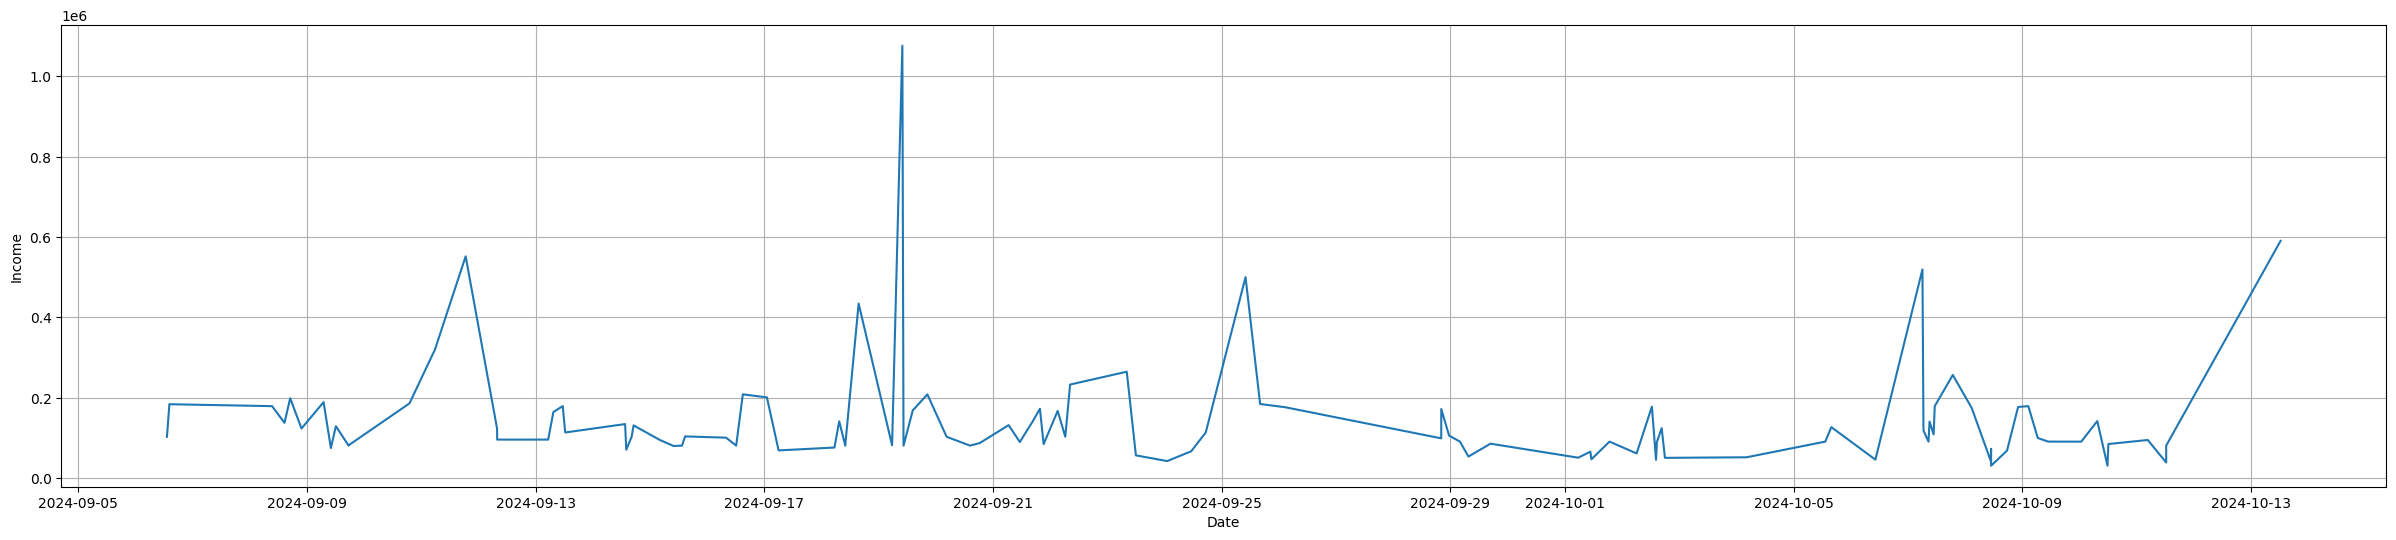

In [15]:
#Plot series

fig, ax = plt.subplots(figsize=(30, 6))
DateFormatter('%m-%d')
plot_series(TIME, SERIES)

In [16]:
# Global Variables

SPLIT_TIME = 50
WINDOW_SIZE = 16
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 75

In [17]:
def train_val_split(time, series):
    """ Splits time series into train and validations sets"""
    time_train = time[:SPLIT_TIME]
    series_train = series[:SPLIT_TIME]
    time_valid = time[SPLIT_TIME:]
    series_valid = series[SPLIT_TIME:]

    return time_train, series_train, time_valid, series_valid

In [18]:
# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(TIME, SERIES)

In [19]:
def windowed_dataset(series, window_size):
    """Creates windowed dataset"""
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(BATCH_SIZE).prefetch(1)

    return dataset

In [20]:
# Apply the transformation to the training set
train_dataset = windowed_dataset(series_train, window_size=WINDOW_SIZE)

In [21]:
# GRADED FUNCTION: create_uncompiled_model
def create_uncompiled_model():
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(WINDOW_SIZE,1)), # Set the correct input shape for the model
        tf.keras.layers.Conv1D(filters=16, kernel_size=3, strides=1, padding="causal", activation="relu"),
        tf.keras.layers.LSTM(16, return_sequences=True),
        tf.keras.layers.LSTM(16),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(1),
    ])

    return model

In [22]:
# Get your uncompiled model
uncompiled_model = create_uncompiled_model()

In [23]:
example_batch = train_dataset.take(1)

try:
	predictions = uncompiled_model.predict(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	print("Your current architecture is compatible with the windowed dataset! :)")
	print(f"predictions have shape: {predictions.shape}")

Your current architecture is compatible with the windowed dataset! :)
predictions have shape: (32, 1)


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [24]:
uncompiled_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 16, 16)              │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 16, 16)              │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 16)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,433 (17.32 KB)

 Trainable params: 4,433 (17.32 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
def adjust_learning_rate(dataset):
    """Fit model using different learning rates"""

    model = create_uncompiled_model()

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

    optimizer = tf.keras.optimizers.Adam(learning_rate=32e-2)

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])

    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

    return history

In [26]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_dataset)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 160520.2656 - mae: 160520.7656 - learning_rate: 1.0000e-04
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 151308.4688 - mae: 151308.9688 - learning_rate: 1.1220e-04
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 161929.6094 - mae: 161930.1094 - learning_rate: 1.2589e-04
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 160416.8750 - mae: 160417.3750 - learning_rate: 1.4125e-04
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 162147.5156 - mae: 162148.0156 - learning_rate: 1.5849e-04
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 160104.3906 - mae: 160104.8906 - learning_rate: 1.7783e-04
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 161072.8594 - mae: 161073.3594 - learning_rate: 1.9953e-04
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 162409.9531 - mae: 162410.4531 - learning_rate: 2.2387e-04
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 160974

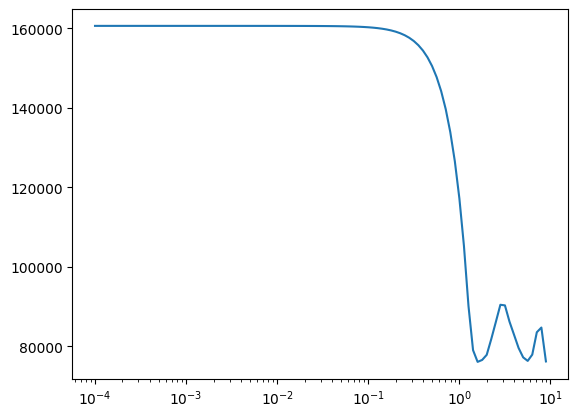

In [27]:
plt.semilogx(lr_history.history["learning_rate"], lr_history.history["loss"])

In [28]:
def create_model():

    model = create_uncompiled_model()

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=32e-2),
                  metrics=["mse"])

    return model

In [29]:
# Save an instance of the model
model = create_model()

In [30]:
# Train it
history = model.fit(train_dataset, epochs=50)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 161672.5625 - mse: 56944979968.0000
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 161052.6719 - mse: 56730955776.0000
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 160958.3750 - mse: 56693731328.0000
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 159849.6094 - mse: 56399544320.0000
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 160682.0469 - mse: 56635314176.0000
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 157240.4688 - mse: 54793711616.0000
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 160545.3125 - mse: 56595271680.0000
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 159684.3906 - mse: 56348758016.0000
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 161316.4219 - mse: 56830132224.0000
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 157244.7969 - mse: 54813097984.0000 
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 160921.203

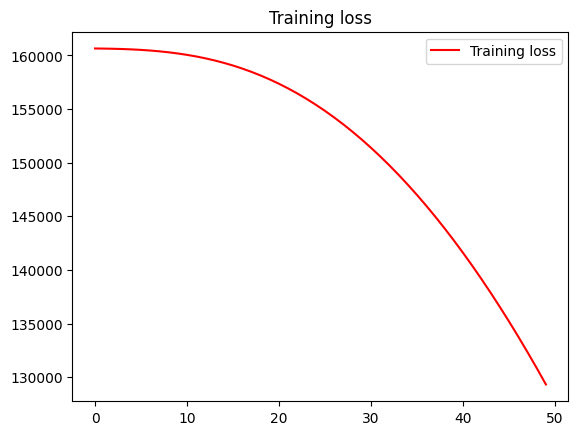

In [31]:
# Plot the training loss for each epoch

loss = history.history['loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.legend(loc=0)
plt.show()

In [32]:
def compute_metrics(true_series, forecast):
    """Computes MSE and MAE metrics for the forecast"""
    mse = tf.keras.losses.MSE(true_series, forecast)
    mae = tf.keras.losses.MAE(true_series, forecast)
    return mse, mae

In [33]:
def model_forecast(model, series, window_size):
    """Generates a forecast using your trained model"""
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [34]:
# Compute the forecast for the validation dataset. Remember you need the last WINDOW SIZE values to make the first prediction
rnn_forecast = model_forecast(model, SERIES[SPLIT_TIME-WINDOW_SIZE:-1], WINDOW_SIZE).squeeze()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 458ms/step


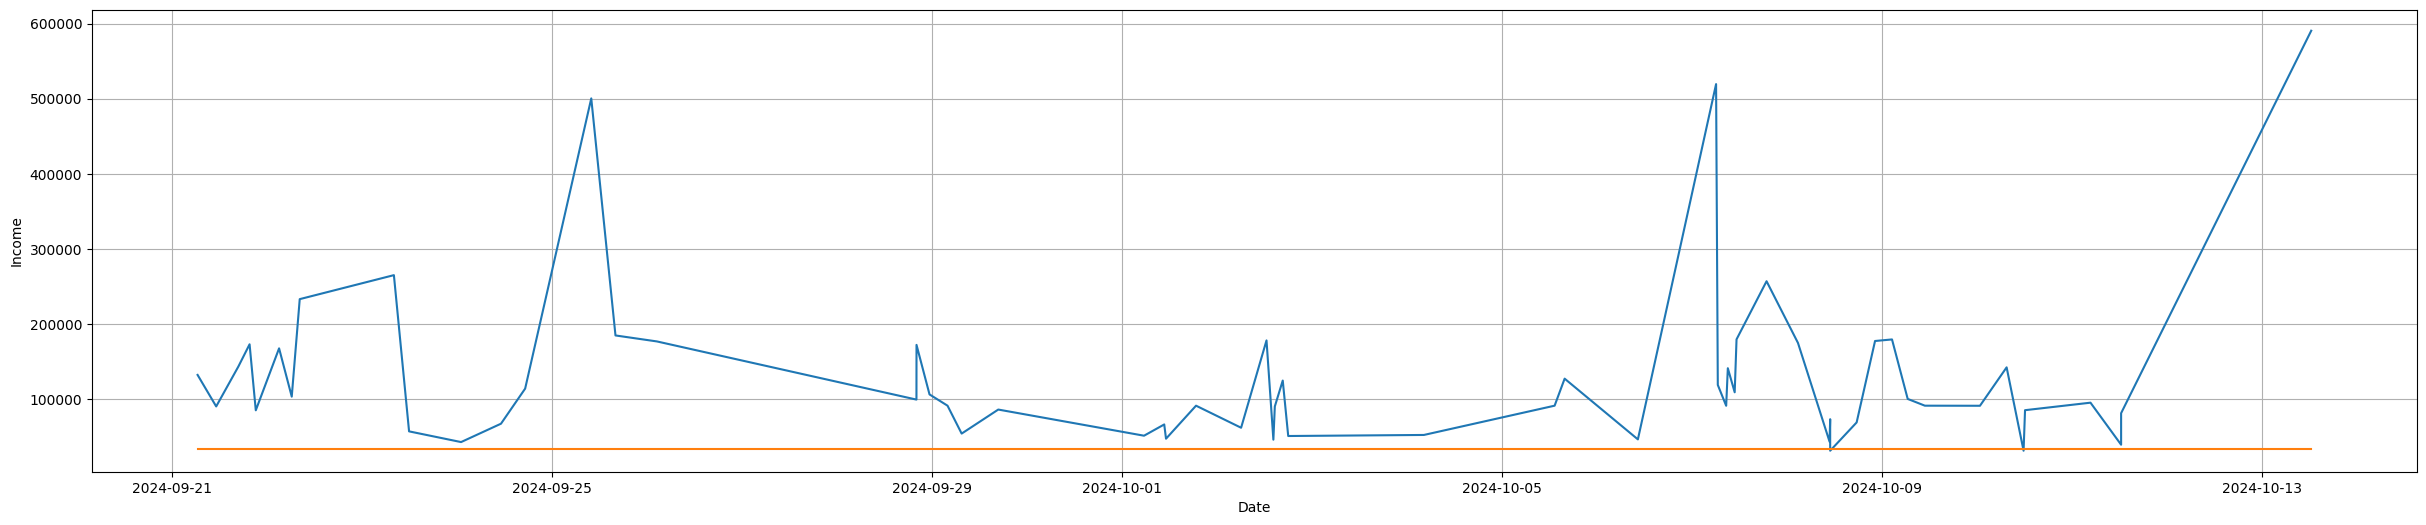

In [35]:
# Plot the forecast
plt.figure(figsize=(30, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [36]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 20783486976.00, mae: 95210.22 for forecast


In [37]:
""" # Save metrics into a dictionary
metrics_dict = {
    "mse": float(mse),
    "mae": float(mae)
}

# Save your metrics in a binary file
with open('metrics.pkl', 'wb') as f:
    pickle.dump(metrics_dict, f)

SyntaxError: incomplete input (<ipython-input-37-c767f62e296a>, line 1)